In [1]:
import asf_search as asf
import earthaccess
import os
import numpy as np
from datetime import datetime

from src.opera_utils import read_opera_cslc
import matplotlib.pyplot as plt
from matplotlib.colors import LightSource

import geopandas as gpd
import folium
from shapely.wkt import loads
from shapely.geometry import Point
from shapely.geometry import box

import h5py

import rasterio
from rasterio.merge import merge
from rasterio.warp import calculate_default_transform, reproject, Resampling
from rasterio.windows import Window
import boto3
from botocore import UNSIGNED
from botocore.config import Config
import math
from urllib.parse import urlparse
import requests

from src.dem_handle import process_dem_for_cslc, plot_dem

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Version check
from watermark import watermark
%load_ext watermark
%watermark --iversions

earthaccess: 0.11.0
geopandas  : 0.13.0
matplotlib : 3.7.1
botocore   : 1.29.76
shapely    : 2.0.6
h5py       : 3.11.0
asf_search : 7.1.3
rasterio   : 1.3.10
requests   : 2.31.0
numpy      : 1.26.3
folium     : 0.15.1
boto3      : 1.26.76
watermark  : 2.5.0



In [3]:
def setup_asf_session():
    """
    Set up ASF session using earthaccess authentication
    Returns authenticated ASF Session object
    """
    # Authenticate using .netrc credentials
    auth = earthaccess.login()
    
    # Create ASF Session with direct netrc authentication
    session = asf.ASFSession()
    
    # Use netrc authentication
    session.auth_with_creds(auth.username, auth.password)
    return session

In [4]:
def search_opera_datasets(session, start_date, end_date, 
                aoi='POLYGON((-121.9658 45.6771,-121.9013 45.6771,-121.9013 45.7112,-121.9658 45.7112,-121.9658 45.6771))',
                dataset=asf.DATASET.OPERA_S1, processingLevel=asf.PRODUCT_TYPE.CSLC, operaBurstID=None):
    """
    Search for datasets based on given parameters
    
    Parameters:
    -----------
    session : ASFSession
        Authenticated ASF session
    start_date : str
        Start date in format 'YYYY-MM-DD'
    end_date : str
        End date in format 'YYYY-MM-DD'
    platform : str
        Satellite platform (default: 'SENTINEL-1A')
    beam_mode : str
        Beam mode (default: 'IW')
    processing_level : str
        Processing level (default: 'GRD_HD')
        
    Returns:
    --------
    list
        List of ASF Granule objects
    """
    # Convert dates to datetime objects
    start = datetime.strptime(start_date, '%Y-%m-%d')
    end = datetime.strptime(end_date, '%Y-%m-%d')
    
    search_params = {
        'dataset': dataset,
        'processingLevel': processingLevel,
        'start': start,
        'end': end,
        'intersectsWith': aoi
    }

    if operaBurstID:
        search_params['operaBurstID'] = operaBurstID
    
    # Perform search
    results = asf.geo_search(**search_params)
    print(f"Found {len(results)} datasets matching criteria")
    return results

In [5]:
def download_datasets(session, results, output_dir):
    """
    Download datasets to specified directory
    
    Parameters:
    -----------
    session : ASFSession
        Authenticated ASF session
    results : list
        List of ASF Granule objects
    output_dir : str
        Directory to save downloaded files
    """
    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)
    
    # Download each dataset
    for i, result in enumerate(results, 1):
        print(f"Downloading dataset {i} of {len(results)}: {result.properties['fileName']}")
        result.download(path=output_dir, session=session)
        print(f"Successfully downloaded {result.properties['fileName']}")

In [6]:
# # Set up session using earthaccess
session = setup_asf_session()

# Example search parameters
start_date = '2022-01-01'
end_date = '2022-01-18'
output_dir = 'asf_downloads'

In [7]:
# Search for datasets
results = search_opera_datasets(session, 
                        start_date=start_date,
                        end_date=end_date,
                        operaBurstID='T115_245667_IW3',
                        aoi='POLYGON((-121.9658 45.6771,-121.9013 45.6771,-121.9013 45.7112,-121.9658 45.7112,-121.9658 45.6771))')

# Download datasets if any found
if results:
    download_datasets(session, results, output_dir)
    print(f"All downloads completed. Files saved to {output_dir}")
else:
    print("No datasets found matching the criteria.")

Found 2 datasets matching criteria
Successfully downloaded OPERA_L2_CSLC-S1_T115-245667-IW3_20220116T141417Z_20240731T102853Z_S1A_VV_v1.1.h5
Successfully downloaded OPERA_L2_CSLC-S1_T115-245667-IW3_20220104T141418Z_20240731T072052Z_S1A_VV_v1.1.h5
All downloads completed. Files saved to asf_downloads


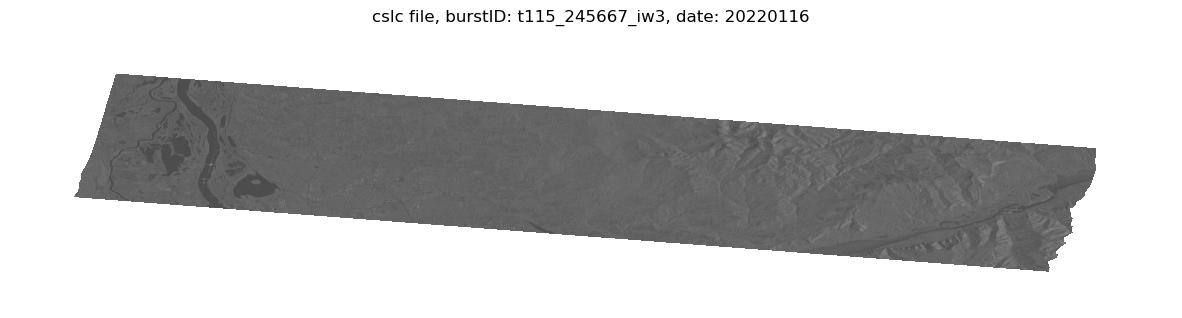

In [8]:
fname = f"{output_dir}/{results[0].properties['fileName']}"

cslc, params = read_opera_cslc(fname)

burst_id = params['burst_id']
sensing_date = datetime.strptime(params['sensing_start'], 
                                "%Y-%m-%d %H:%M:%S.%f").strftime("%Y%m%d")

fig, ax = plt.subplots(figsize=(15,10))
ax.imshow(np.abs(cslc)**0.1, cmap='gray')
ax.axis('off')
ax.set_title(f'cslc file, burstID: {burst_id}, date: {sensing_date}')
plt.show()

In [9]:
def plot_polygon_on_map(polygon_str: str, center_lat: float = None, center_lon: float = None) -> folium.Map:
    """
    Plot a WKT polygon string on a folium map with switchable base layers.
    
    Args:
        polygon_str (str): WKT polygon string in format 'POLYGON((...))'
        center_lat (float, optional): Center latitude for map. If None, calculated from polygon
        center_lon (float, optional): Center longitude for map. If None, calculated from polygon
        
    Returns:
        folium.Map: Map with polygon overlay and layer control
    """
    # Convert WKT string to shapely polygon
    polygon = loads(polygon_str)
    
    # Extract coordinates
    coords = list(polygon.exterior.coords)
    
    # Convert to list of [lat, lon] for folium
    folium_coords = [[lat, lon] for lon, lat in coords]
    
    # Calculate center if not provided
    if center_lat is None or center_lon is None:
        center_lat = np.mean([coord[0] for coord in folium_coords])
        center_lon = np.mean([coord[1] for coord in folium_coords])
    
    # Create empty base map
    m = folium.Map(
        location=[center_lat, center_lon],
        zoom_start=10,
        control_scale=True,
        tiles=None
    )
    
    # Add ESRI Satellite as default base layer
    folium.TileLayer(
        tiles='https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}',
        attr='Esri',
        name='ESRI Satellite',
        overlay=False,
        control=True
    ).add_to(m)
    
    # Add OpenStreetMap as additional layer
    folium.TileLayer(
        tiles='OpenStreetMap',
        name='OpenStreetMap',
        overlay=False,
        control=True,
        show=False
    ).add_to(m)
    
    # Add polygon to map
    folium.Polygon(
        locations=folium_coords,
        color='red',
        weight=2,
        fill=True,
        fill_color='red',
        fill_opacity=0.2,
        popup='CSLC Coverage',
        name='CSLC Coverage'
    ).add_to(m)
    
    # Add layer control
    folium.LayerControl(position='topright').add_to(m)
    
    return m

In [10]:
polygon_str = params['bounding_polygon']
center_lat = params['center_lat']
center_lon = params['center_lon']

m = plot_polygon_on_map(polygon_str, center_lat, center_lon)

display(m)

### <I>**Download water mask and DEM**</I>

In [11]:
def download_worldcover(lon, lat, output_dir='worldcover', year=2021):
    """
    Download ESA WorldCover tile for given coordinates using ESA's S3 bucket.
    
    Args:
        lon (float): Longitude of the point of interest
        lat (float): Latitude of the point of interest
        output_dir (str): Directory to save the downloaded file
        year (int): Year of the map (2020 or 2021)
    
    Returns:
        str: Path to the downloaded file
    """
    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)
    
    # Get version based on year
    version = 'v200' if year == 2021 else 'v100'
    
    # First, get the grid file to determine the tile
    s3_url_prefix = "https://esa-worldcover.s3.eu-central-1.amazonaws.com"
    grid_url = f'{s3_url_prefix}/v100/2020/esa_worldcover_2020_grid.geojson'
    
    print("Downloading WorldCover grid file...")
    
    # Download and read the grid file
    grid = gpd.read_file(grid_url)
    
    # Create point geometry from lon, lat
    point = Point(lon, lat)
    
    # Find the tile that contains this point
    containing_tile = grid[grid.contains(point)]
    
    if containing_tile.empty:
        raise ValueError(f"No WorldCover tile found for coordinates: lon={lon}, lat={lat}")
    
    # Get the tile name
    tile_name = containing_tile.iloc[0].ll_tile
    
    # Construct the file URL and name
    file_name = f"ESA_WorldCover_10m_{year}_{version}_{tile_name}_Map.tif"
    url = f"{s3_url_prefix}/{version}/{year}/map/{file_name}"
    local_file = os.path.join(output_dir, file_name)
    
    # Check if file already exists
    if os.path.exists(local_file):
        print(f"WorldCover tile already exists at {local_file}")
        return local_file
    
    print(f"Downloading WorldCover tile {tile_name}...")
    
    try:
        response = requests.get(url, allow_redirects=True)
        response.raise_for_status()
        
        with open(local_file, 'wb') as f:
            f.write(response.content)
            
        print(f"Downloaded WorldCover tile to {local_file}")
        return local_file
        
    except requests.exceptions.HTTPError as e:
        print(f"Error downloading from {url}")
        raise e

In [12]:
def get_water_mask(params, worldcover_file):
    """Create a water mask from ESA WorldCover data, reprojected to match CSLC coordinates."""
    epsg = params['epsg']
    x_coords = params['x_coordinates']
    y_coords = params['y_coordinates']
    
    # Create target raster profile
    dst_shape = (len(y_coords), len(x_coords))
    dst_bounds = (min(x_coords), min(y_coords), max(x_coords), max(y_coords))
    dst_res = ((dst_bounds[2] - dst_bounds[0]) / dst_shape[1],
               (dst_bounds[3] - dst_bounds[1]) / dst_shape[0])
    
    # Initialize output array
    water_mask = np.zeros(dst_shape, dtype=np.uint8)
    
    with rasterio.open(worldcover_file) as src:
        # Create output transform
        dst_transform = rasterio.transform.from_bounds(*dst_bounds, dst_shape[1], dst_shape[0])
        
        # Perform reprojection
        reproject(
            source=rasterio.band(src, 1),
            destination=water_mask,
            src_transform=src.transform,
            src_crs=src.crs,
            dst_transform=dst_transform,
            dst_crs=f'EPSG:{epsg}',
            resampling=Resampling.nearest
        )
    
    return water_mask == 80  # ESA WorldCover class 80 is water

In [13]:
def create_shaded_relief(dem, azimuth=315, altitude=45):
    """
    Create shaded relief from DEM data.
    
    Parameters:
    -----------
    dem : numpy.ndarray
        DEM elevation data
    azimuth : float
        Direction of light source in degrees (0=North, 90=East)
    altitude : float
        Height of light source in degrees above horizon
    
    Returns:
    --------
    numpy.ndarray
        Shaded relief array
    """
    # Create light source object
    ls = LightSource(azdeg=azimuth, altdeg=altitude)
    
    # Create shaded relief
    relief = ls.hillshade(dem)
    
    return relief

In [14]:
def visualize_data(amp=None, water_mask=None, dem=None, fig_dir='figures', 
                  titles=None, plot_scale=0.1):
    """
    Visualize combinations of CSLC amplitude, water mask, and DEM data.
    
    Parameters:
    -----------
    amp : numpy.ndarray, optional
        CSLC amplitude data
    water_mask : numpy.ndarray, optional
        Water mask data (boolean array)
    dem : numpy.ndarray, optional
        DEM elevation data
    fig_dir : str, optional
        Directory to save figures
    titles : dict, optional
        Custom titles for each subplot
    plot_scale : float, optional
        Scale factor for amplitude display
    """
    # Count number of data arrays provided
    data_arrays = [arr for arr in [amp, water_mask, dem] if arr is not None]
    n_plots = len(data_arrays)
    
    if n_plots == 0:
        raise ValueError("At least one data array must be provided")
    
    # Default titles
    default_titles = {
        'amp': 'CSLC Amplitude',
        'water_mask': 'Water Mask (Blue = Water)',
        'dem': 'Digital Elevation Model'
    }
    
    # Use provided titles or defaults
    titles = titles or default_titles
    
    # Create figure
    fig = plt.figure(figsize=(20, 6*n_plots))
    
    # Plot each provided dataset
    plot_idx = 1
    
    # Amplitude plot
    if amp is not None:
        ax = plt.subplot(n_plots, 1, plot_idx)
        im = ax.imshow(amp**plot_scale, cmap='gray')
        ax.set_title(titles.get('amp', default_titles['amp']))
        ax.axis('off')
        plot_idx += 1
    
    # Water mask plot
    if water_mask is not None:
        ax = plt.subplot(n_plots, 1, plot_idx)
        im = ax.imshow(water_mask, cmap='Blues')
        ax.set_title(titles.get('water_mask', default_titles['water_mask']))
        ax.axis('off')
        plot_idx += 1
    
    # plot shaded relief DEM
    if dem is not None:
        ax = plt.subplot(n_plots, 1, plot_idx)
        
        # Create shaded relief
        relief = create_shaded_relief(dem)
        
        # Plot shade relief DEM
        # im_dem = ax.imshow(dem, cmap='terrain', alpha=0.8)
        # ax.imshow(relief, cmap='gray', alpha=0.2)
        im_dem = ax.imshow(relief, cmap='gray', alpha=1.0)
        
        ax.set_title(titles.get('dem', default_titles['dem']))
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()

In [15]:
# Download ESA WorldCover and extract water mask
worldcover_file = download_worldcover(params['center_lon'], params['center_lat'])
water_mask = get_water_mask(params, worldcover_file)

Downloaded WorldCover tile to worldcover/ESA_WorldCover_10m_2021_v200_N45W123_Map.tif


In [16]:
# Streaming GLS-30 DEM in AWS S3 bucket and processing for CSLC-S1
dem_data = process_dem_for_cslc(
    params,
    merged_output='merged_dem.tif',
    final_output='reprojected_dem.tif') # download_path for downloading the DEM

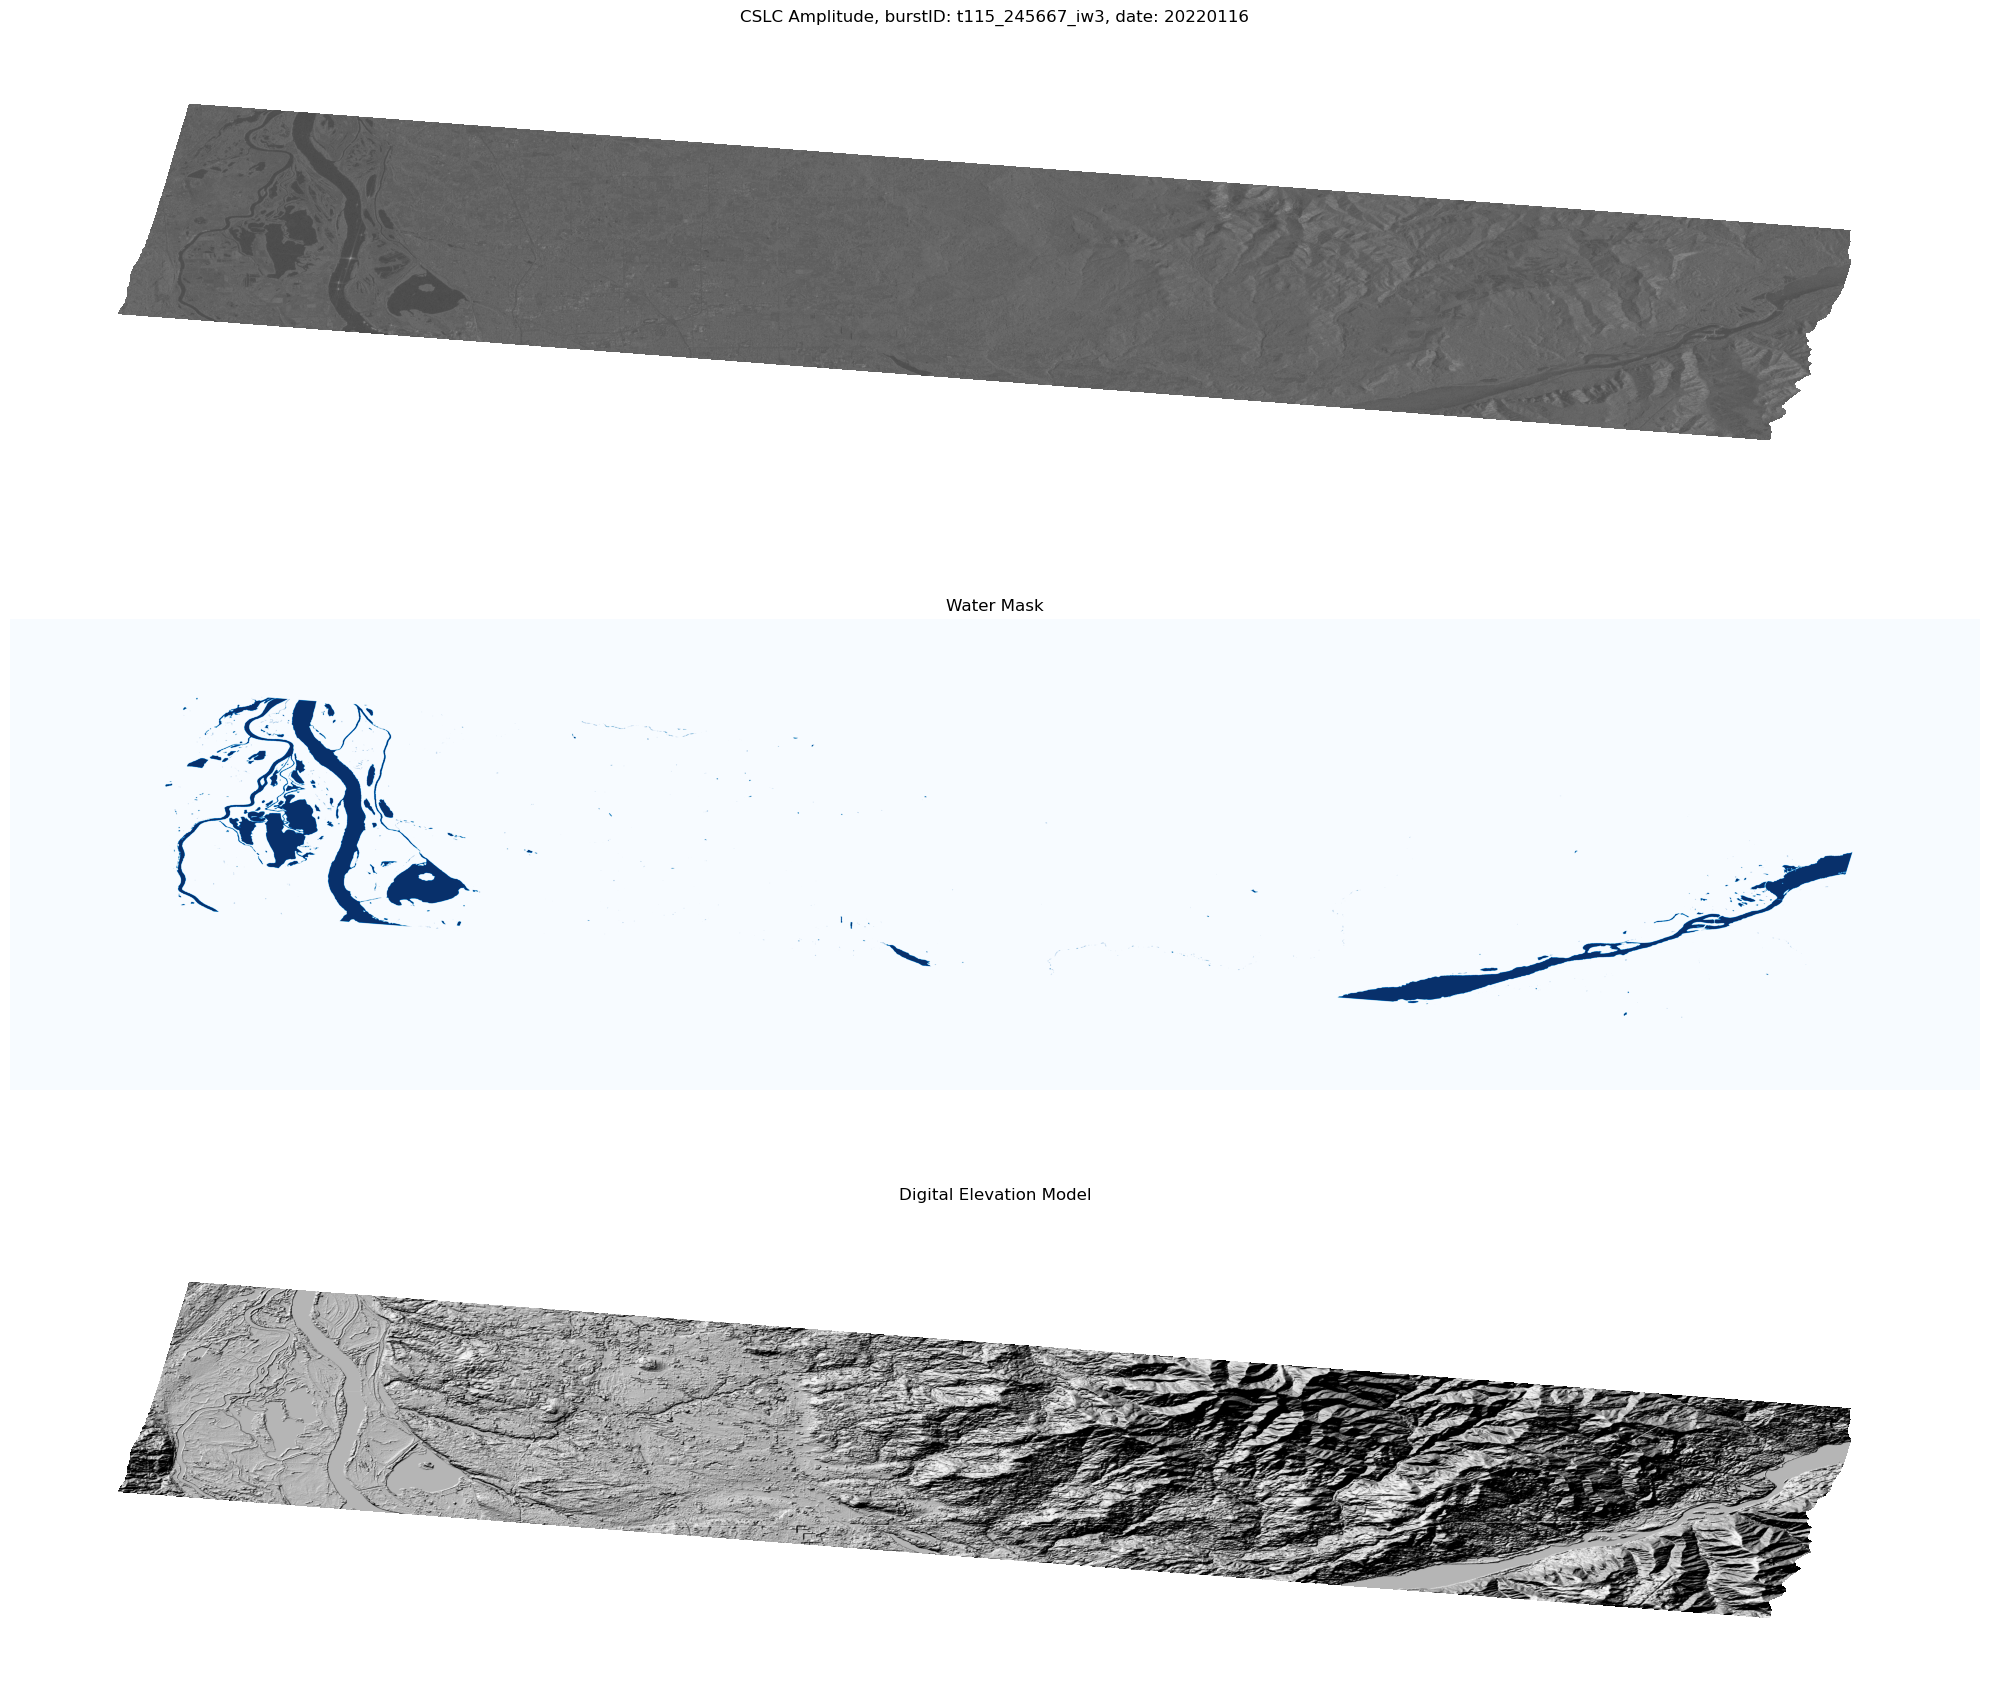

In [17]:
# Visualize water mask
plot_scale = 0.1
water_mask[np.isnan(cslc)] = 0
dem_data[np.isnan(cslc)] = np.nan

visualize_data(amp=np.abs(cslc), 
               water_mask=water_mask, 
               dem=dem_data,
               titles={
                   'amp': f'CSLC Amplitude, burstID: {burst_id}, date: {sensing_date}',
                   'water_mask': 'Water Mask',
                   'dem': 'Digital Elevation Model'
               }, plot_scale = plot_scale)

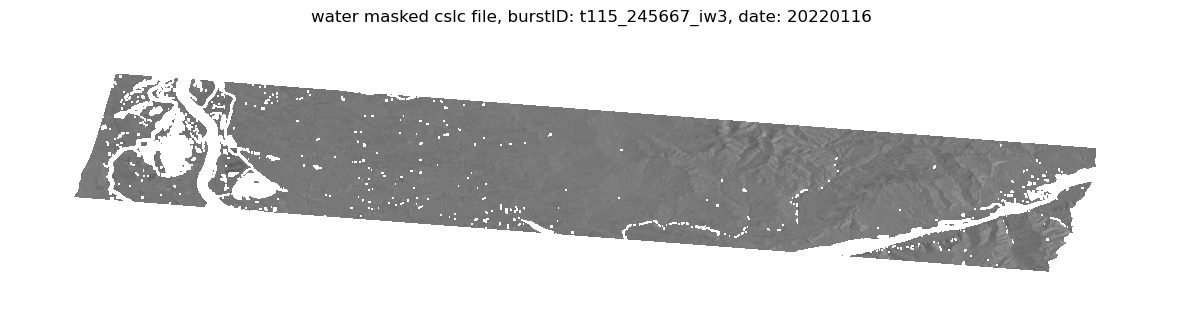

In [18]:
# Display water masked cslc file
cslc_masked = cslc.copy()
cslc_masked[water_mask] = np.nan

fig, ax = plt.subplots(figsize=(15,10))
ax.imshow(np.abs(cslc_masked)**plot_scale, cmap='gray')
ax.set_title(f'water masked cslc file, burstID: {burst_id}, date: {sensing_date}')
ax.axis('off')
plt.show()